## 数据预处理
1. 生成train（ID、Rtitle、RContent、Atitle、AContent、Level）和test（ID、Rtitle、RContent、Atitle、AContent）文件，其中Rtitle、RContent、Atitle、AContent都是分词、去停用词之后的文本；

2. 得到词汇表（索引从1开始，0用来决补齐操作），生成词向量

In [1]:
import pandas as pd
import numpy as np
import jieba
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from gensim.models import word2vec

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


对技术需求、技术成果文本进行中文分词 确定词汇表

In [2]:
requirements_path = ".//Requirements.csv"  # 技术需求
train_achievements_path = ".//Train_Achievements.csv"  # 训练集中的技术成果
test_achievements_path = ".//Test_Achievements.csv"  # 测试集中的技术成果

In [3]:
def read_doc(path, columns):
    """读取技术需求文档或者技术成果文档"""
    data = []
    for line in open(path, 'r', encoding='utf-8'):
        lines = line.split(",")
        data.append([lines[0].strip(), lines[1].strip(), ",".join(lines[2:]).strip()])
    return pd.DataFrame(data, columns=columns)

In [4]:
requirements = read_doc(requirements_path, ['rid', 'rtitle', 'rcontent'])
train_achievements = read_doc(train_achievements_path, ['aid', 'atitle', 'acontent'])
test_achievements = read_doc(test_achievements_path, ['aid', 'atitle', 'acontent'])

In [5]:
requirements['rid'] = requirements['rid'].apply(lambda x : x.replace("""'""", "").replace("""'""", "").replace(" ", ""))
train_achievements['aid'] = train_achievements['aid'].apply(lambda x : x.replace("""'""", "").replace("""'""", "").replace(" ", ""))
test_achievements['aid'] = test_achievements['aid'].apply(lambda x : x.replace("""'""", "").replace("""'""", "").replace(" ", ""))

In [6]:
"""加载停用词"""
stopwords = set()
for line in open(".//HIT_stop_words.txt", 'r', encoding='utf-8'):
    stopwords.add(line.replace("\n", ""))

"""文本分词函数"""
def word_cut(text):
    words = jieba.cut(text, cut_all=False)
    words = [word for word in words if word not in stopwords]
    return " ".join(words)

In [7]:
title_maxlen = 20
content_maxlen = 400
requirements['rtitle_words'] = requirements['rtitle'].apply(lambda x : word_cut(x))
requirements['rcontent_words'] = requirements['rcontent'].apply(lambda x : word_cut(x))
train_achievements['atitle_words'] = train_achievements['atitle'].apply(lambda x : word_cut(x))
train_achievements['acontent_words'] = train_achievements['acontent'].apply(lambda x : word_cut(x))
test_achievements['atitle_words'] = test_achievements['atitle'].apply(lambda x : word_cut(x))
test_achievements['acontent_words'] = test_achievements['acontent'].apply(lambda x : word_cut(x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.700 seconds.
Prefix dict has been built succesfully.


In [20]:
# 查看分词后 title 和 content的长度分布
title_len_count = {}
content_len_count = {}

for words in requirements['rcontent_words']:
    words = words.split(" ")
    length = len(words)
    if length not in content_len_count.keys():
        content_len_count[length] = 0
    content_len_count[length] += 1
for words in train_achievements['acontent_words']:
    words = words.split(" ")
    length = len(words)
    if length not in content_len_count.keys():
        content_len_count[length] = 0
    content_len_count[length] += 1
for words in test_achievements['acontent_words']:
    words = words.split(" ")
    length = len(words)
    if length not in content_len_count.keys():
        content_len_count[length] = 0
    content_len_count[length] += 1
    
for words in requirements['rtitle_words']:
    words = words.split(" ")
    length = len(words)
    if length not in title_len_count.keys():
        title_len_count[length] = 0
    title_len_count[length] += 1
for words in train_achievements['atitle_words']:
    words = words.split(" ")
    length = len(words)
    if length not in title_len_count.keys():
        title_len_count[length] = 0
    title_len_count[length] += 1
for words in test_achievements['atitle_words']:
    words = words.split(" ")
    length = len(words)
    if length not in title_len_count.keys():
        title_len_count[length] = 0
    title_len_count[length] += 1

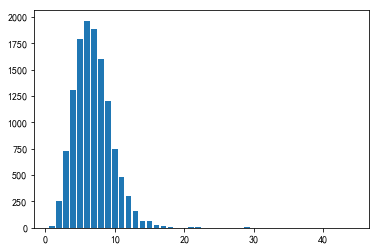

In [23]:
lens = []
counts = []
for key, value in title_len_count.items():
    lens.append(key)
    counts.append(value)
plt.bar(lens, counts)
plt.show()

title的长度取 20   

content的长度取 400

In [26]:
word_count = {}  # 词汇_出现次数
for data in [requirements['rcontent_words'], requirements['rtitle_words'], train_achievements['acontent_words'], train_achievements['atitle_words'], test_achievements['atitle_words'], test_achievements['acontent_words']]:
    for words in data:
        for word in words.split(" "):
            if word not in word_count.keys():
                word_count[word] = 0
            word_count[word] += 1

In [27]:
print(len(word_count))

74158


In [33]:
word2index = {}
index = 1
count = 0
for key in word_count.keys():
    if word_count[key] <= 5 or len(key) == 1:
        count += 1
    else:
        word2index[key] = index
        index += 1
print(len(word2index))

25179


In [37]:
def filter_words(text):
    tmp = []
    for word in text.split(" "):
        if word in word2index.keys():
            tmp.append(word)
    return " ".join(tmp)

In [38]:
print(filter_words("社会 不断"))

社会 不断


In [39]:
# 过滤不在词汇表的词
requirements['rtitle_words'] = requirements['rtitle_words'].apply(lambda x : filter_words(x))
requirements['rcontent_words'] = requirements['rcontent_words'].apply(lambda x : filter_words(x))
train_achievements['atitle_words'] = train_achievements['atitle_words'].apply(lambda x : filter_words(x))
train_achievements['acontent_words'] = train_achievements['acontent_words'].apply(lambda x : filter_words(x))
test_achievements['atitle_words'] = test_achievements['atitle_words'].apply(lambda x : filter_words(x))
test_achievements['acontent_words'] = test_achievements['acontent_words'].apply(lambda x : filter_words(x))

In [40]:
def judge_words(text):
    for word in text.split(" "):
        if word not in word2index.keys():
            print(word)
    return text

In [41]:
requirements['rtitle_words'] = requirements['rtitle_words'].apply(lambda x : judge_words(x))
requirements['rcontent_words'] = requirements['rcontent_words'].apply(lambda x : judge_words(x))
train_achievements['atitle_words'] = train_achievements['atitle_words'].apply(lambda x : judge_words(x))
train_achievements['acontent_words'] = train_achievements['acontent_words'].apply(lambda x : judge_words(x))
test_achievements['atitle_words'] = test_achievements['atitle_words'].apply(lambda x : judge_words(x))
test_achievements['acontent_words'] = test_achievements['acontent_words'].apply(lambda x : judge_words(x))

In [44]:
from gensim.models import word2vec
corpus = []
for data in [requirements['rcontent_words'], requirements['rtitle_words'], train_achievements['acontent_words'], train_achievements['atitle_words'], test_achievements['atitle_words'], test_achievements['acontent_words']]:
    for words in data:
        corpus.append(words.split(" "))

In [46]:
model = word2vec.Word2Vec(corpus, size=200, hs=1, min_count=1, window=5)

In [49]:
for i in model.wv.most_similar(u"铸铁"):
    print (i[0],i[1])

铸钢 0.623816728591919
耐磨 0.5283143520355225
铝及 0.5122253894805908
轧辊 0.5096081495285034
铜合金 0.5036332011222839
厚壁 0.48569416999816895
双金属 0.4788305461406708
钛合金 0.47431057691574097
不锈钢 0.4700304865837097
铸件 0.46754640340805054


In [51]:
model.save(".//gensim-word2vec-200.model")
pickle.dump(word2index, open(".//vocabulary.pkl", "wb"))

In [52]:
print(requirements.columns)
print(train_achievements.columns)
print(test_achievements.columns)

Index(['rid', 'rtitle', 'rcontent', 'rtitle_words', 'rcontent_words'], dtype='object')
Index(['aid', 'atitle', 'acontent', 'atitle_words', 'acontent_words'], dtype='object')
Index(['aid', 'atitle', 'acontent', 'atitle_words', 'acontent_words'], dtype='object')


In [53]:
requirements = requirements[['rid', 'rtitle_words', 'rcontent_words']]
train_achievements = train_achievements[['aid', 'atitle_words', 'acontent_words']]
test_achievements = test_achievements[['aid', 'atitle_words', 'acontent_words']]

In [54]:
requirements.to_csv(".//requirements_words.csv", index=None, encoding="utf-8")
train_achievements.to_csv(".//train_achievements_words.csv", index=None, encoding="utf-8")
test_achievements.to_csv(".//test_achievements_words.csv", index=None, encoding="utf-8")

In [55]:
train_path = ".//Train_Interrelation.csv"
test_path = ".//TestPrediction.csv"

In [56]:
train = pd.read_csv(open(train_path, "r", encoding="utf-8"), header=0, names=['id', 'aid','rid', 'level'])
test = pd.read_csv(open(test_path, "r", encoding="utf-8"), header=0, names=['id', 'aid','rid', 'level'])

In [57]:
# 进行关联操作
train_data = pd.merge(train, requirements, on='rid')
train_data = pd.merge(train_data, train_achievements, on='aid')

In [58]:
test_data = pd.merge(test, requirements, on='rid')
test_data = pd.merge(test_data, test_achievements, on='aid')

In [59]:
train_data.to_csv(".//train.csv", index=None, encoding="utf-8")
test_data.to_csv(".//test.csv", index=None, encoding="utf-8")

In [61]:
for id in test['id']:
    if id not in list(test_data['id']):
        print(id)

00663e38-1a01-45c7-b214-74a5db890d0b
